# One-shot learning (N-way) using Omniglot data set and Siamese Neural Networks

This notebook shows an implementation version of the paper [koch et al, Siamese Neural Networks for One-shot Image Recognition](http://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).

The model has been created with [keras](https://keras.io/).

**NOTE: Bear in mind this is a work in progress repository and there is plenty of room for improvements in the components as well as for the one-shot experiments.**

## One-shot learning (N-way)

Humans learn new concepts with very little supervision – e.g. a child can generalize the concept
of “giraffe” from a single picture in a book.

Deep learning has made major advances in areas such as speech, vision and language, but is notorious for requiring large datasets.

The process of learning good features for machine learning applications can be very computationally expensive and may prove difficult in cases where little data is available.

One-shot learning is a clasification problem in machine learning, that aims to learn information about classes from one, or only a few, training examples.

A one-shot task aims to classify a test example X, into one of the N unique classes (N-way) of a support set S, which is a small subset of the all available C classes.

The model is given the support set and a test example that has to classify.

Since exactly one example in the support set has the right class of the test example, the aim is to correctly predict which support example is the same as the test example.

## Omniglot data set

The data set contains 50 alphabets total, splitted into a background set of 30 alphabets and an evaluation set of 20 alphabets. There is no overlap between the training and evaluation sets.

Each alphabet has a number of characters from 14 to 55 different characters drawn by 20 different subjects, resulting in 20 105x105 images for each character with a total of 1623 character classes.

The background set is only used to learn general knowledge about characters (e.g., hyperparameter inference or feature learning). One-shot learning results are reported using alphabets from the evaluation set.

![alt text](./images/omniglot_general.png "Omniglot Data Set")

Following are some of the alphabets represented in the data set:

![alt text](./images/omniglot_alphabets.png "Omniglot Alphabets")

An example of a one-shot 20-way task in this dataset can be seen in the following figure:
    
![alt text](./images/omniglot_20_way.png "Omniglot 20-way task")

### Omniglot Service

The data set is retrieved using OmniglotService class.

It download and unzip the data set to the path specified when creating the class (./data by default) within the train_set and test_set folders respectively.

In [1]:
from omniglot_service import OmniglotService

data_service = OmniglotService()
data_service.get_data()

Unziping data/images_background.zip to data
Rename data/images_background to data/train_set
Unziping data/images_evaluation.zip to data
Rename data/images_evaluation to data/test_set


You can also retrieve the data by set type (train/test) and specify the folder name where will be unzip.

In [2]:
data_service.get_data_type('test_alphabets', data_type='test')

Unziping data/images_evaluation.zip to data
Rename data/images_evaluation to data/test_alphabets


Data folder content after getting the data:

In [3]:
!ls ./data

test_alphabets test_set       train_set


Below there is a summary of the folders content:

In [4]:
print("Train Set:")
number_alphabets = !ls ./data/train_set | wc -l
print(f'Number of alphabets = {number_alphabets[0]}')
alphabets = !ls ./data/train_set | head -5
print(f'First five alphabets = {alphabets}')
classes = !ls ./data/train_set/Alphabet_of_the_Magi | head -5
print(f'First five classes of first alphabet = {classes}')
images = !ls ./data/train_set/Alphabet_of_the_Magi/character01 | head -5
print(f'First five images of first character of first alphabet = {images}')
print()
print("Test Set:")
number_alphabets = !ls ./data/test_set | wc -l
print(f'Number of alphabets  = {number_alphabets[0]}')
alphabets = !ls ./data/test_set | head -5
print(f'First five alphabets = {alphabets}')
classes = !ls ./data/test_set/Angelic | head -5
print(f'First five classes of first alphabet = {classes}')
images = !ls ./data/test_set/Angelic/character01 | head -5
print(f'First five images of first character of first alphabet = {images}')

Train Set:
Number of alphabets =       30
First five alphabets = ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']
First five classes of first alphabet = ['character01', 'character02', 'character03', 'character04', 'character05']
First five images of first character of first alphabet = ['0709_01.png', '0709_02.png', '0709_03.png', '0709_04.png', '0709_05.png']

Test Set:
Number of alphabets  =       20
First five alphabets = ['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta']
First five classes of first alphabet = ['character01', 'character02', 'character03', 'character04', 'character05']
First five images of first character of first alphabet = ['0965_01.png', '0965_02.png', '0965_03.png', '0965_04.png', '0965_05.png']


### Omniglot Loader

The data set is loaded into memory from the specified data set types folders using OmniglotLoader class.

If any of the folders doesn't exist the loader uses the OmniglotService to retrieve de data set.

Each data set type is stored in a tuple respectively with the first element being the data and the second the classes in the format 'alphabet/character' and saved to a pickle file to load it more quickly in subsequents loads.

In [5]:
from omniglot_loader import OmniglotLoader

omniglot_loader = OmniglotLoader(path='./data', train_folder='train_set', test_folder='test_set')
train_set, test_set = omniglot_loader.load_data()

Loading data from data/train_set
Saving data to data/train.pickle
Loading data from data/test_set
Saving data to data/test.pickle


In [6]:
train_set, test_set = omniglot_loader.load_data()

Loading data from data/train.pickle
Loading data from data/test.pickle


Below there is a summary of the tuple's content:

In [7]:
print("Train Set:")
classes, images_per_class, height, width, channels = train_set[0].shape
print(f'Number of classes = {classes}')
print(f'Images per class  = {images_per_class}')
print(f'Image shape (H,W,C) = {height}, {width}, {channels}')
print(f'First five classes = {train_set[1][0:5]}')
print()
print("Test Set:")
classes, images_per_class, height, width, channels = test_set[0].shape
print(f'Number of classes = {classes}')
print(f'Images per class  = {images_per_class}')
print(f'Image shape (H,W,C) = {height}, {width}, {channels}')
print(f'First five classes = {test_set[1][0:5]}')
print()
common_classes = set(train_set[1])&set(test_set[1])
print(f'Number of classes in both data sets = {len(common_classes)}')

Train Set:
Number of classes = 964
Images per class  = 20
Image shape (H,W,C) = 105, 105, 1
First five classes = ['Alphabet_of_the_Magi/character01' 'Alphabet_of_the_Magi/character02'
 'Alphabet_of_the_Magi/character03' 'Alphabet_of_the_Magi/character04'
 'Alphabet_of_the_Magi/character05']

Test Set:
Number of classes = 659
Images per class  = 20
Image shape (H,W,C) = 105, 105, 1
First five classes = ['Angelic/character01' 'Angelic/character02' 'Angelic/character03'
 'Angelic/character04' 'Angelic/character05']

Number of classes in both data sets = 0


Following is a random sample of each data set:

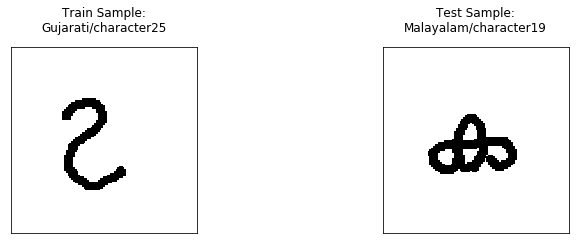

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def display_image_pair(first_item, second_item):
    fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
    ax1.matshow(first_item[0], cmap='gray')
    ax2.matshow(second_item[0], cmap='gray')
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.set_title(f'Train Sample:\n{first_item[1]}')
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.set_title(f'Test Sample:\n{second_item[1]}')
    plt.subplots_adjust(wspace=1)
    plt.show()
    
train_class = np.random.randint(train_set[1].shape[0])
train_image = train_set[0][train_class][0].reshape(height, width)
test_class = np.random.randint(len(test_set[1]))
test_image = test_set[0][test_class][0].reshape(height, width)

display_image_pair((train_image, train_set[1][train_class]), (test_image, test_set[1][test_class]))

### Omniglot Dataset

The in memory data set is managed using OmniglotDataset class.

The class load the data set using the OmniglotLoader class and split the train set in train and validation sets, leaving the test set unaltered.

In [9]:
from omniglot_dataset import OmniglotDataset

omniglot_dataset = OmniglotDataset()
omniglot_dataset.load()

Loading data from data/train.pickle
Loading data from data/test.pickle


Each of the data sets tuple (train, validation and test) can be accessed using the corresponding class property/variable.
Each data set type is stored in a tuple respectively with the first element being the data and the second the classes in the format 'alphabet/character' and they can be accessed using the corresponding instance property/variable.

In [10]:
print('Train Set:')
print(f'Shape = {omniglot_dataset.train_set[0].shape}')
print(f'Classes: {omniglot_dataset.train_set[1][:5]}...{omniglot_dataset.train_set[1][-5:]}')
print()
print('Validation Set:')
print(f'Shape = {omniglot_dataset.val_set[0].shape}')
print(f'Classes: {omniglot_dataset.val_set[1][:5]}...{omniglot_dataset.val_set[1][-5:]}')
print()
print('Test Set:')
print(f'Shape = {omniglot_dataset.test_set[0].shape}')
print(f'Classes: {omniglot_dataset.test_set[1][:5]}...{omniglot_dataset.test_set[1][-5:]}')

Train Set:
Shape = (673, 20, 105, 105, 1)
Classes: ['Alphabet_of_the_Magi/character01' 'Alphabet_of_the_Magi/character02'
 'Alphabet_of_the_Magi/character03' 'Alphabet_of_the_Magi/character04'
 'Alphabet_of_the_Magi/character05']...['Korean/character36' 'Korean/character37' 'Korean/character38'
 'Korean/character39' 'Korean/character40']

Validation Set:
Shape = (291, 20, 105, 105, 1)
Classes: ['Latin/character01' 'Latin/character02' 'Latin/character03'
 'Latin/character04' 'Latin/character05']...['Tifinagh/character51' 'Tifinagh/character52' 'Tifinagh/character53'
 'Tifinagh/character54' 'Tifinagh/character55']

Test Set:
Shape = (659, 20, 105, 105, 1)
Classes: ['Angelic/character01' 'Angelic/character02' 'Angelic/character03'
 'Angelic/character04' 'Angelic/character05']...['ULOG/character22' 'ULOG/character23' 'ULOG/character24'
 'ULOG/character25' 'ULOG/character26']


The class also has a property/variable with the data shape that uses the different data set types:

In [11]:
omniglot_dataset.data_shape

(105, 105, 1)

The class also have two helper methods to retrieve random classes from a data set type:

In [12]:
train_classes = omniglot_dataset.get_data_classes(4)
print(f'Returned train classes = {omniglot_dataset.train_set[1][train_classes]}')
print()
val_classes = omniglot_dataset.get_data_classes(4, data_type='val')
print(f'Returned validation classes = {omniglot_dataset.val_set[1][val_classes]}')
print()
test_classes = omniglot_dataset.get_data_classes(4, data_type='test')
print(f'Returned test classes = {omniglot_dataset.test_set[1][test_classes]}')

Returned train classes = ['Arcadian/character09' 'Bengali/character19' 'Gujarati/character42'
 'Burmese_(Myanmar)/character14']

Returned validation classes = ['Latin/character04' 'Malay_(Jawi_-_Arabic)/character05'
 'Mkhedruli_(Georgian)/character41' 'N_Ko/character29']

Returned test classes = ['Syriac_(Serto)/character12' 'Malayalam/character17' 'Keble/character16'
 'Kannada/character36']


And another method to get a random pair of images of the same/different class/es from a data set type, in this case the train data set type:

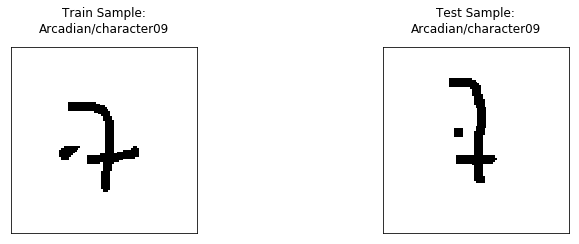

In [13]:
first_class = train_classes[0]
first_class_name = omniglot_dataset.train_set[1][first_class]
first_image, second_image = omniglot_dataset.get_image_pair(first_class, data_type='train', same_class='true')
display_image_pair((first_image.reshape(height, width), first_class_name), 
                   (second_image.reshape(height, width), first_class_name))

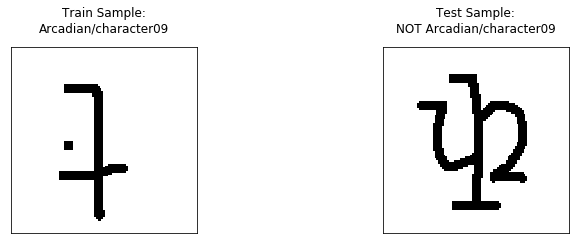

In [14]:
first_class = train_classes[0]
first_class_name = omniglot_dataset.train_set[1][first_class]
first_image, second_image = omniglot_dataset.get_image_pair(first_class, data_type='train')
display_image_pair((first_image.reshape(height, width), first_class_name), 
                   (second_image.reshape(height, width), f'NOT {first_class_name}'))

Both methods will be used by the runner to create batchs of data.

## Siamese Neural Networks

Siamese nets were first introduced in the early 1990s by Bromley and LeCun to solve signature verification as an image matching problem [Bromley et al., 1993](https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf). 

A siamese neural network consists of twin networks which accept distinct inputs but are joined by an energy function at the top. This function computes some metric between the highestlevel feature representation on each side. 

The parameters between the twin networks are tied. Weight tying guarantees that two extremely similar images could not possibly be mapped by their respective networks to very different locations in feature space because each network computes the same function. 

Also, the network is symmetric, so that whenever we present two distinct images to the twin networks, the top conjoining layer will compute the same metric as if we were to present the same two images but to the opposite twins.

![alt text](./images/siamese_networks.png "Siamese Neural Networks")

The paper uses the weighted L1 distance between the twin feature vectors h1 and h2 combined with a sigmoid activation, which maps onto the interval [0, 1]. Thus a cross-entropy objective is a natural choice for training the network.

The CNN architecture of each network has 9 layers, including Max Pooling and Convolutional layers of different filter sizes.
These 9 layers work as feature extractor/selector for the siamese architecture.

![alt text](./images/feature_extractor.png "Feature Extractor Network")

All layers in the feature extractor are initialized with weights having 0 mean 0.01 standard deviation, and bias with a mean value of 0.5 and a standard deviation of 0.01, except for the first convolutional layer (the input layer), which its bias are not initialized. L2 regularization of 0.0004 is also used for all layers except for the last one that uses 0.002.

Adam optimizer with the default configuration has been used to compile the model.

### Siamese Net

The SiameseNet class create an instance of the siamese networks with the specific data input that is passed in the constructor, in this case the one defined by omniglot_dataset.data_shape property.

The instance created has a model property/variable whichs contains the keras model.

In [15]:
from siamese_net import SiameseNet

siamese_net = SiameseNet(omniglot_dataset.data_shape)
siamese_net.model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_encoder_input (InputLayer) (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
right_encoder_input (InputLayer (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
encoder (Sequential)            (None, 4096)         38947648    left_encoder_input[0][0]         
                                                                 right_encoder_input[0][0]        
__________________________________________________________________________________________________
l1_distance (Lambda)            (None, 4096)         0           encoder[1][0]                    
          

Following is the layers of one of the feature extractor networks:

In [16]:
siamese_net.model.layers[2].layers

The model loss, metrics and optimizer configuration:

In [17]:
print(f'Model loss function: {siamese_net.model.loss}')
print(f'Model metric functions: {siamese_net.model.metrics}')
print(f'Model optimizer: {siamese_net.model.optimizer}')

Model loss function: binary_crossentropy
Model metric functions: ['accuracy']
Model optimizer: <keras.optimizers.Adam object at 0xb1f3815c0>


### One Shot Runner

The OneShotRunner class run one-shot experiments on a model using a specific data set.

The model and data set are passed as parameters when creating the runner instance, in our case we create the runner object with a omniglot data set and a siamese network model.

In [18]:
from one_shot_runner import OneShotRunner

one_shot_runner = OneShotRunner(omniglot_dataset, siamese_net.model)

A runner instance has two methods, train and predict in order to run experiments.

Train method, as the name suggests, train the model using the data set for a series of iterations, using a specific n-way value and evaluating the training performance on the validation set with a specific number of validations.

All those parameters are configurable in the method signature, the default configuration is for experiments on one-shot 20-way tasks with epochs of 10000 iterations each and 50 validation on the validation data set type for each evaluation.

In [19]:
one_shot_runner.train(number_way=20, number_iterations=10000, number_validations=50)

The runner reports/save the following parameters during the training process:

- Report training loss and accuracy every 100 iterations
- Report validation loss and accuracy every 1000 iterations
- Save training/evaluation state (loss and accuracy) every 1000 iterations
- Save the model weights at the end of the process

All the parameters are stored at the ./model folder within the training_data.pickle and model_weights.h5 files respectively.

Below is the output that the training process reports while executing:

*Start training for 10000 iterations with 50 validations per each one-shot 20-way task  
iteration 100, loss = 3.24, accuracy = 78.12  
iteration 200, loss = 2.52, accuracy = 90.62  
iteration 300, loss = 2.20, accuracy = 84.38  
iteration 400, loss = 1.92, accuracy = 90.62  
iteration 500, loss = 1.72, accuracy = 87.50  
iteration 600, loss = 1.48, accuracy = 96.88  
iteration 700, loss = 1.44, accuracy = 90.62  
iteration 800, loss = 1.45, accuracy = 84.38  
iteration 900, loss = 1.23, accuracy = 96.88  
iteration 1000, loss = 1.13, accuracy = 93.75  
evaluation at iteration 1000, loss = 0.33, accuracy = 60.00  
Saving training data at iteration 1000  
iteration 1100, loss = 1.08, accuracy = 90.62  
...  
...  
...  
iteration 9900, loss = 0.11, accuracy = 100.00  
iteration 10000, loss = 0.12, accuracy = 100.00  
evaluation at iteration 10000, loss = 0.06, accuracy = 94.00  
Saving training data at iteration 10000  
Saving model weights*

Saving the model state/data allow us to start the experiment in an specific training point, to do so, we just need to enable the corresponding flag parameter in the train method, which is disabled by default.

In [20]:
one_shot_runner.train(preload_state=True)

*Preloading model weights  
Preloading training data  
Start training for 10000 iterations with 50 validations per each one-shot 20-way task  
...  
...  
...  *

Every iteration, the model is feeded with batches of 32 samples from the train set, each sample is 2 omniglot images.

Half of the batch samples uses a pair of images that belong to the same class and the other half belong to different classes.
The classes of the first image of each sample are different and picked randomly from the train data set.
The batch is shuffle before feeding the model.

A 8 samples batch would be as displayed below.

**NOTE THAT THE METHOD IS PUBLIC JUST TO SHOW HOW A TRAINING BATCH IS, IT SHOULD BE ENCAPSULATED (PRIVATE) IN THE RUNNER CLASS AND THE BATCH_SIZE BE CONFIGURABLE**

In [21]:
inputs, labels = one_shot_runner.get_train_batch(batch_size=8)

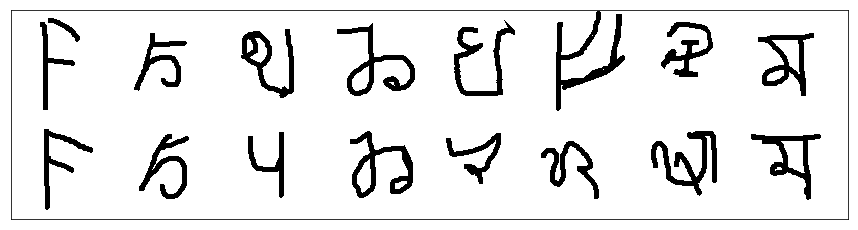

Labels: [1. 1. 0. 1. 0. 0. 0. 1.]


In [22]:
from functools import reduce

def display_batch(first_input, second_input):
    first_input = first_input.squeeze()
    second_input = second_input.squeeze()
    first_plot = reduce((lambda x, y: np.append(x, y, axis=1)), first_input)
    second_plot = reduce((lambda x, y: np.append(x, y, axis=1)), second_input)
    final_plot = np.append(first_plot, second_plot, axis=0)
    fig,(ax1) = plt.subplots(1, 1, figsize=(15, 15))
    ax1.matshow(final_plot, cmap='gray')
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    plt.show()
display_batch(*inputs)
print(f'Labels: {labels}')

Every evaluation is made using a one-shot 20-way task per each validation. An example of a one-shot 20-way task input is as follow:

**NOTE THAT AGAIN, THE METHOD IS PUBLIC JUST TO SHOW HOW A ONE-SHOT TASK BATCH IS.**

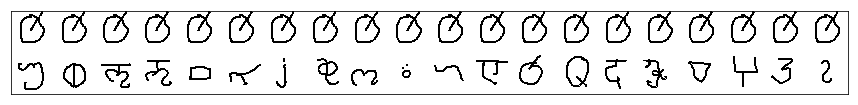

Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
inputs, labels = one_shot_runner.get_one_shot_batch(batch_size=20, data_type='val')
display_batch(*inputs)
print(f'Labels: {labels}')

Predict method, as the name suggests, predicts the output of a one-shot 20-way task using the trained model. 

A number of predictions are done for all data set types (train, validation and test) with a number of validation per predictions.

Each validation, the model is feeded with a one-shot N-way task batch generated from the corresponding data set type (train, validation or test) as showed above.

All those parameters are configurable in the method signature, the default configuration is for predictions on one-shot 20-way tasks with 100 predictions and 50 validations for each prediction.

In [24]:
one_shot_runner.predict(number_way=20, number_iterations=1000, number_validations=50)

The runner reports/save the following parameters during the prediction process:

- Report prediction iteration every 10 iterations
- Save prediction accuracy (train, validation and test) at the end of the process

The predictions are stored at the ./model folder within the prediction_data.pickle.

Below is the output that the prediction process reports while executing:

*Start predictions for 100 iterations with 50 validations per each one-shot 20-way task  
Predictions at iteration 10 finished  
Predictions at iteration 20 finished  
Predictions at iteration 30 finished  
Predictions at iteration 40 finished  
Predictions at iteration 50 finished  
Predictions at iteration 60 finished  
Predictions at iteration 70 finished  
Predictions at iteration 80 finished  
Predictions at iteration 90 finished  
Predictions at iteration 100 finished  
Saving prediction data to model/predictions_data.pickle  *

The prediction can be done using a specific model state, we just need to enable the corresponding flag parameter in the predict method, which is disabled by default.

In [25]:
one_shot_runner.predict(preload_state=True)

*Preloading model weights  
Start predictions for 100 iterations with 50 validations per each one-shot 20-way task  
...  
...  
...*

## Experiments

With all the described components in place we can start running one-shot N-way task experiments.

### Default Configuration Experiment

The most basic experiment would be to simply create all the components with the default configuration and train the network for an epoch and test the quality of the predictions.

The code would be as follow:

```python
#Create omniglot data set instace
omniglot_dataset = OmniglotDataset() 

#Create siamese network with an specific data input shape and default configuration
siamese_net = SiameseNet(omniglot_dataset.data_shape)

#Create a one-shot runner instance with a specific data set and model
one_shot_runner = OneShotRunner(omniglot_dataset, siamese_net.model)

#Run the experiment, this time with the default configuration
one_shot_runner.train()
one_shot_runner.predict()
```

Once the experiment finishes, all the data generated can be processed and displayed using the Utils and RunnerVisualizer components.

The Utils class has two static methods to save/read data in pickle format and is used by some components to store/load data.

The RunnerVisualizer class has three static methods to display the loss, accuracy and predictions data respectively.

For the experiment with the default configuration we can see that the network doesn't converge and the results are very bad for any of the data set types, having more or less an accuracy average of 8% for all of them.

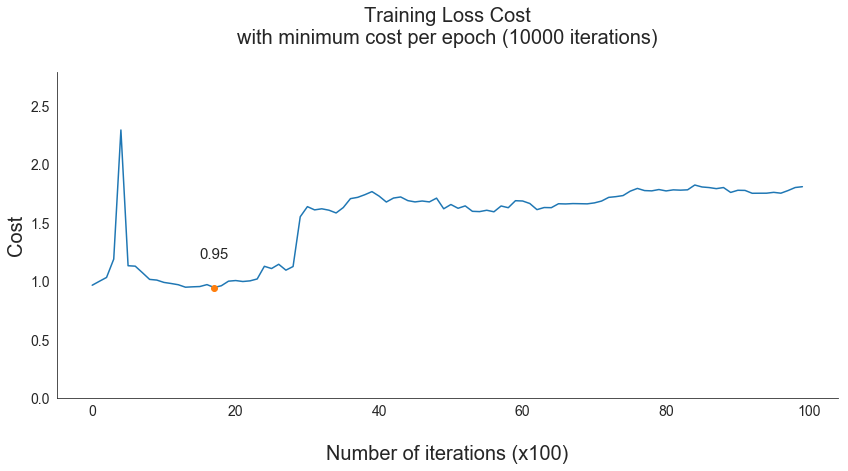

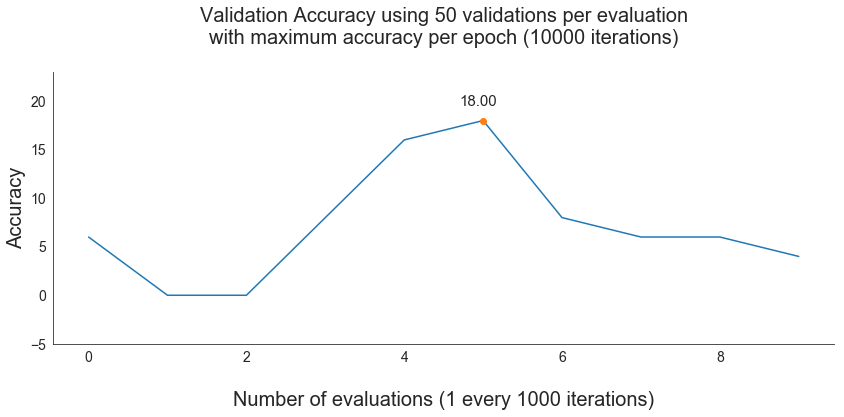

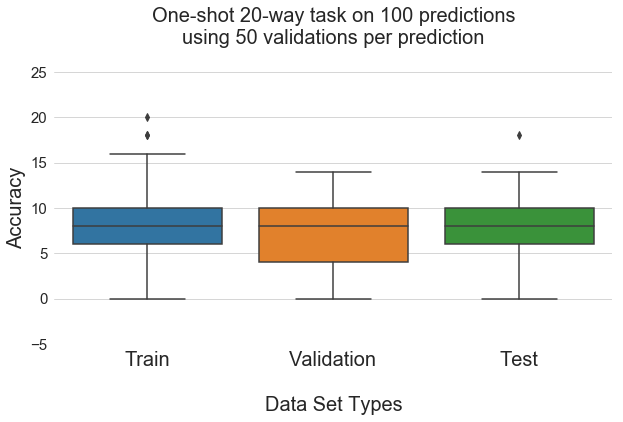

In [26]:
from utils import Utils
from runner_visualizer import RunnerVisualizer

def report_results(model_folder):
    training_data = Utils.read_data(f'./{model_folder}/training_data.pickle')
    training_loss, training_accuracy, validation_loss, validation_accuracy = training_data
    predictions_data = Utils.read_data(f'./{model_folder}/predictions_data.pickle')
    train_accuracy, val_accuracy, test_accuracy = predictions_data

    RunnerVisualizer.display_loss(training_loss);
    print('\n\n\n')
    RunnerVisualizer.display_accuracy(validation_accuracy);
    print('\n\n\n')
    data = [train_accuracy, val_accuracy, test_accuracy]
    RunnerVisualizer.display_predictions(data)
    
model_folder = 'experiments/model_default_parameters'
report_results(model_folder)

### Learning Rate = 0.00005 Experiment

The code would be as follow:

```python
#Create omniglot data set instace
omniglot_dataset = OmniglotDataset() 

#Create siamese network with an specific data input shape
siamese_net = SiameseNet(omniglot_dataset.data_shape)

#Configure the model with the desired parameters, learning rate of 0.00005 this time
from keras import backend as K
K.set_value(siamese_net.model.optimizer.lr, 0.00005)

#Create a one-shot runner instance with a specific data set and model
one_shot_runner = OneShotRunner(omniglot_dataset, siamese_net.model)

#Run the experiment, this time during 40000 iterations (4 epochs)
one_shot_runner.train(number_iterations=40000)
one_shot_runner.predict()
```

For the experiment with the above configuration we can see that the network this time converges and the results are much better, achieving an average accuracy of 82% for the test set, but with a worst case scenario of 68%.

We can also see that the cost is decreasing each epoch but the validation accuracy did not improve during the third epoch but it did a lot at the end of the last epoch.

The model has overfitted the train set which achieves an accuracy average of 96%, which suggets that there is still plenty room for improvement and also knowing that author of the paper obtained a test result of 92%.

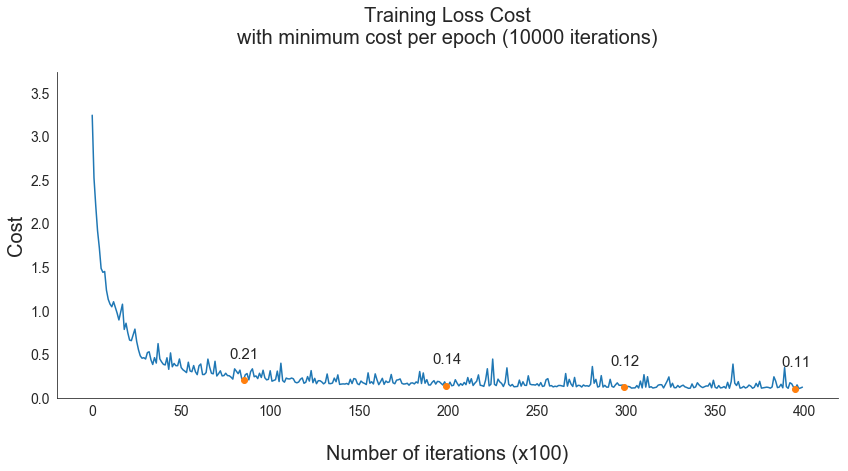

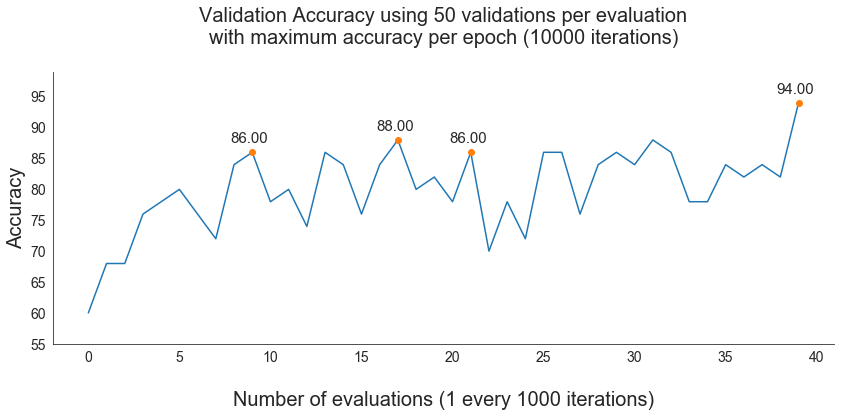

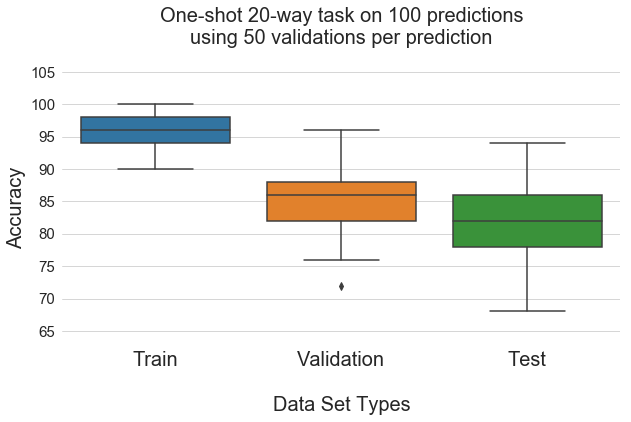

In [27]:
model_folder = 'experiments/model_lr'
report_results(model_folder)